# Profitability and Volatility Analysis of Bitcoin (BTC)

This work applies quantitative finance techniques with real data, meeting the requested requirements:

1. Exploratory analysis of daily returns (mean, standard deviation, plots).
2. Distribution fitting (Normal vs. t-Student) using Q–Q plots and formal tests.
3. Calculation of Value at Risk (VaR) at 1% using the historical method.
4. Calculation of VaR at 1% using the Variance–Covariance method.
5. Calculation of VaR at 1% using Monte Carlo simulation.
6. Calculation of VaR at 1% using Extreme Value Theory (EVT), Hill estimator, and Hill plot.

The data used covers the period from January 1, 2020 to September 1, 2025.

## Importing libraries and data

The data is obtained from Yahoo Finance (or from a previously downloaded CSV file to ensure reproducibility).


In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Download Bitcoin data from Yahoo Finance
data = yf.download('BTC-USD', start='2020-01-01', end='2025-09-01', auto_adjust=True)
# data.to_csv("./data/BTC-USD.csv")

# Compute logarithmic returns
data['LogRet'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


## 1. Exploratory analysis of daily returns

- Compute the mean and standard deviation of returns.  
- Plot the series of daily returns and its histogram.  

**Interpretation:** These results allow us to evaluate the average profitability and volatility of Bitcoin during the analyzed period.

mean    0.001310
std     0.032949
min    -0.464730
25%    -0.012810
50%     0.000626
75%     0.015367
max     0.171821
Name: LogRet, dtype: float64


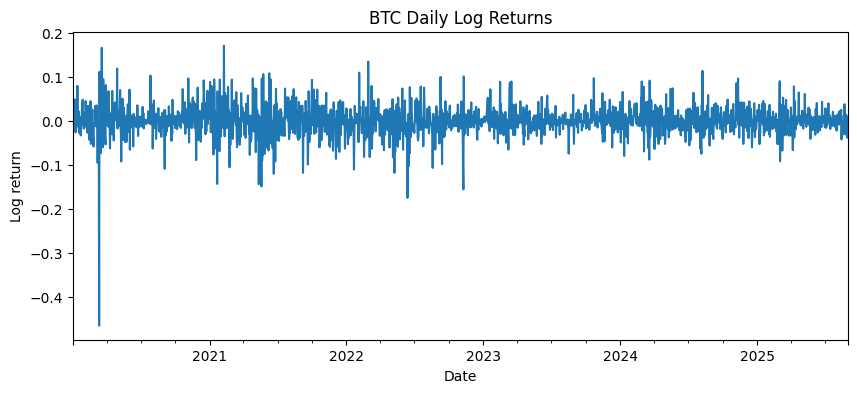

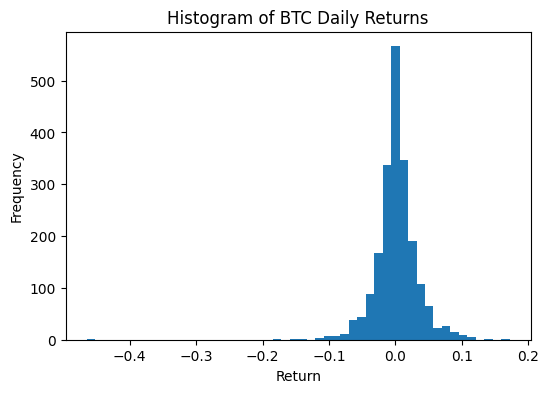

In [2]:
# Summary statistics of log returns
desc = data['LogRet'].describe()
print(desc[['mean','std','min','25%','50%','75%','max']])

# Plot daily log returns
data['LogRet'].plot(figsize=(10,4), title='BTC Daily Log Returns')
plt.ylabel('Log return')
plt.show()

# Plot histogram of daily returns
plt.figure(figsize=(6,4))
plt.hist(data['LogRet'], bins=50)
plt.title('Histogram of BTC Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

## 2. Distribution fitting: Normal vs t-Student

We compare the fit of returns to two distributions:

- **Normal:** commonly assumed in classical models.  
- **t-Student:** better suited to capture heavy tails.  

**Tests used:**  
- Q–Q plots to visually compare empirical vs theoretical distributions.  
- Kolmogorov–Smirnov (KS) test to assess statistical fit.  

**Conclusion:** The t-Student distribution usually fits financial assets better because it captures fat tails more effectively.

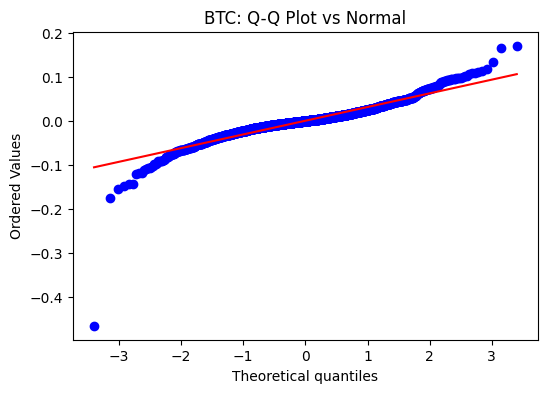

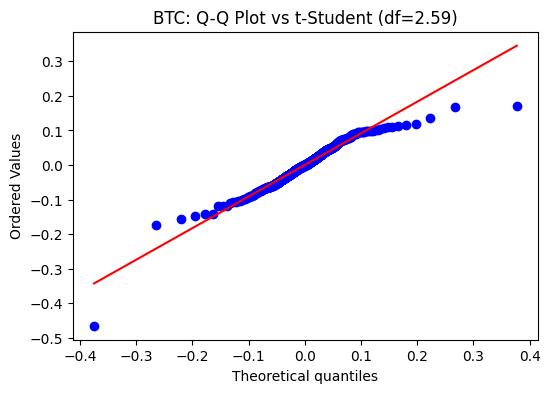

KS Normal: statistic=0.0933, p-value=0.0000
KS t-Student: statistic=0.0231, p-value=0.2150


In [3]:
# Q-Q plot against Normal distribution
plt.figure(figsize=(6,4))
stats.probplot(data['LogRet'], dist="norm", plot=plt)
plt.title('BTC: Q-Q Plot vs Normal')
plt.show()

# Q-Q plot against t-Student distribution
params = stats.t.fit(data['LogRet'])
plt.figure(figsize=(6,4))
stats.probplot(data['LogRet'], dist=stats.t(df=params[0], loc=params[1], scale=params[2]), plot=plt)
plt.title(f"BTC: Q-Q Plot vs t-Student (df={params[0]:.2f})")
plt.show()

# Kolmogorov-Smirnov tests
d_n, p_n = stats.kstest(data['LogRet'], 'norm', args=(data['LogRet'].mean(), data['LogRet'].std()))
d_t, p_t = stats.kstest(data['LogRet'], 't', args=(params[0], params[1], params[2]))
print(f"KS Normal: statistic={d_n:.4f}, p-value={p_n:.4f}")
print(f"KS t-Student: statistic={d_t:.4f}, p-value={p_t:.4f}")

## 3. Value at Risk (VaR) at 1% – Historical Method

**Definition:** The historical VaR at 1% is the 1st percentile of the empirical return distribution.  

**Result:** It represents the maximum expected loss with 99% confidence over a 1-day horizon.

In [4]:
# Historical Value at Risk (1%)
var_hist = np.percentile(data['LogRet'], 1)
print(f"Historical VaR 1%: {var_hist:.4f} (log-return)")
print(f"Historical VaR 1%: {-var_hist*100:.2f}%")


Historical VaR 1%: -0.0897 (log-return)
Historical VaR 1%: 8.97%


## 4. Value at Risk (VaR) at 1% – Variance-Covariance Method

**Assumption:** Returns follow a Normal distribution.  

**Formula:**  
$$
VaR = \mu + \sigma z_{0.01}
$$

**Comparison with the historical method:**  
This highlights the impact of assuming normality versus using actual empirical data.


In [5]:
# Variance-Covariance Value at Risk (1%)
mu = data['LogRet'].mean()
sigma = data['LogRet'].std()
z = stats.norm.ppf(0.01)

var_vc = mu + sigma * z
print(f"VaR Var-Cov 1%: {var_vc:.4f} (log-return)")
print(f"VaR Var-Cov 1%: {-var_vc*100:.2f}%")

VaR Var-Cov 1%: -0.0753 (log-return)
VaR Var-Cov 1%: 7.53%


## 5. Value at Risk (VaR) at 1% – Monte Carlo Simulation

**Methodology:** We simulate 10,000 one-day scenarios using a Geometric Brownian Motion (GBM) model.  

**Result:** The 1st percentile of the simulated returns corresponds to the VaR.  

**Interpretation:** This approach is useful for incorporating stochastic assumptions and conducting scenario analysis.

In [6]:
# Monte Carlo Simulation for Value at Risk (1%)
S0 = float(data['Close'].iloc[-1]) 
T = 1/252
num_sim = 10000
np.random.seed(42)

mu_ann = mu * 252
sigma_ann = sigma * np.sqrt(252)

rand = np.random.normal(0, 1, num_sim)
S1 = S0 * np.exp((mu_ann - 0.5*sigma_ann**2) * T + sigma_ann * np.sqrt(T) * rand)
rets_mc = np.log(S1 / S0)

var_mc = np.percentile(rets_mc, 1)
print(f"Monte Carlo VaR 1%: {-var_mc*100:.2f}%")


Monte Carlo VaR 1%: 7.57%


## 6. Value at Risk (VaR) at 1% – Extreme Value Theory (EVT)

**Procedure:**
1. Select a threshold (5th percentile) to isolate extreme events.  
2. Fit the tail with a Generalized Pareto Distribution (GPD).  
3. Compute the 1% VaR using the Hill estimator.  

**Hill plot:** Used to analyze the stability and convergence of the shape parameter.  

**Interpretation:** EVT provides a more robust framework for modeling fat tails compared to the Normal distribution.


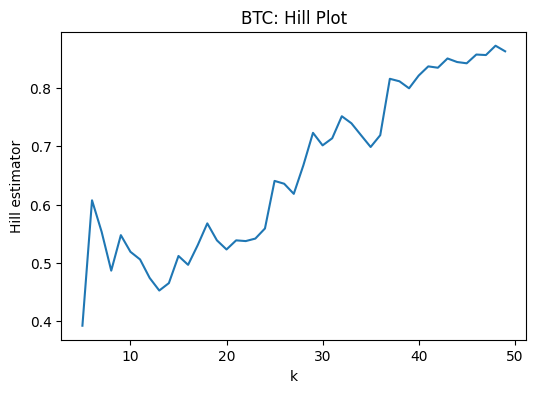

EVT VaR 1%: 8.95% loss


In [7]:
# Extreme Value Theory (EVT) for Value at Risk (1%)
thresh = np.percentile(data['LogRet'], 5)
losses = -data['LogRet']
excesses = losses[losses > -thresh] - (-thresh)

# Hill estimator function
def hill_estimator(x, k):
    x_sorted = np.sort(x)
    return (1/k) * np.sum(np.log(x_sorted[-k:] / x_sorted[-k-1]))

# Compute Hill estimates for different k
ks = np.arange(5, min(len(excesses) - 1, 50))
hills = [hill_estimator(excesses.values, k) for k in ks]

# Plot Hill estimator
plt.figure(figsize=(6,4))
plt.plot(ks, hills)
plt.title('BTC: Hill Plot')
plt.xlabel('k')
plt.ylabel('Hill estimator')
plt.show()

# Fit Generalized Pareto Distribution
xi, loc, beta = stats.genpareto.fit(excesses.values)
alpha = 0.01
N = len(losses)
n_u = len(excesses)

# EVT VaR estimation
VaR_evt = -thresh + (beta/xi) * ((N/n_u * alpha) ** (-xi) - 1)
print(f"EVT VaR 1%: {VaR_evt*100:.2f}% loss")

# Conclusions – Bitcoin (BTC)

1. The t-Student distribution fits BTC returns much better than the Normal, with low degrees of freedom (~2.6), confirming the presence of extremely heavy tails.  
2. The historical VaR at 1% indicates losses close to **9% per day**, reflecting BTC’s high volatility and frequency of extreme drops.  
3. The Variance–Covariance and Monte Carlo methods (under Normality) give lower values (~7.5%), showing a **significant underestimation of risk** when Normality is assumed.  
4. The EVT approach estimates a 1% VaR very close to the historical (~9%), confirming that BTC data already includes severe extreme events (such as the -46% drop in March 2020), validating the robustness of this method for crypto assets.  

**Implication:** For BTC, Normality-based methods are clearly insufficient. EVT and historical VaR converge in showing a very heavy-tailed risk profile, highlighting the need for approaches that explicitly capture the extreme nature of this asset.

---

# Comparison BTC vs AAPL

- For **AAPL**, the difference between Normal and EVT was moderate: Normal underestimates, but still comes close to the data.  
- For **BTC**, Normal clearly fails: it significantly underestimates risk, while Historical and EVT agree on extreme losses (~9%).  
- **BTC shows much heavier tails** (df ≈ 2.6) compared to AAPL (df ≈ 4.1), confirming that extreme shocks are intrinsic to its dynamics.  
- In practice, a risk manager could cautiously accept the Normal assumption for traditional assets like AAPL, but for BTC heavy-tailed or EVT models are indispensable.  

---

# Comparative Table of 1% VaR (log-returns)

| Method            | AAPL (2020–2023) | BTC (2020–2025) |
|-------------------|------------------|-----------------|
| Historical        | **5.92%**        | **8.97%**       |
| Var-Cov (Normal)  | 5.33%            | 7.53%           |
| Monte Carlo (GBM) | 5.35%            | 7.57%           |
| EVT (GPD/Hill)    | **8.47%**        | **8.95%**       |
